In [ ]:
# Cell 1: Import necessary libraries
import json
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import spacy
from gensim.models import Word2Vec, Doc2Vec, LdaModel
from gensim.models.doc2vec import TaggedDocument
from gensim.corpora import Dictionary
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pickle
import os
import glob
import scipy.sparse as sparse


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nlp = spacy.load('en_core_web_md')

ramdom_seed = np.random.seed(42)

# Create directories for processed data
# os.makedirs('processed_data', exist_ok=True)
# os.makedirs('models', exist_ok=True)

[nltk_data] Downloading package punkt to /Users/waternav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/waternav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/waternav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
# Load Python dictionary from json and save to csv files
import pandas as pd
import os
import re
import ast 
from tqdm.notebook import tqdm

def load_python_dict_data():
    print("Loading data in Python dictionary literal format...")
    
    # os.makedirs('processed_data', exist_ok=True)
    
    # List of files to process
    files = [
        # 'data/australian_user_reviews.json',
        # 'data/steam_reviews.json',
        # 'data/steam_games.json',
        # 'data/bundle_data.json',
        # 'data/australian_users_items.json'
    ]
    
    data_dict = {}
    
    for filename in files:
        try:
            print(f"Processing {filename}...")
            data_list = []
            
            # Count lines for progress bar (not efficient but i need it lol)
            with open(filename, 'r', encoding='utf-8') as f:
                total_lines = sum(1 for _ in f)
            
            # Process file line by line with progress bar
            with open(filename, 'r', encoding='utf-8') as f:
                for line in tqdm(f, total=total_lines, desc=f"Reading {filename}"):
                    line = line.strip()
                    if not line:
                        continue
                    try:
                        data = ast.literal_eval(line)
                        data_list.append(data)
                    except (SyntaxError, ValueError) as e:
                        print(f"Error parsing line: {str(e)}")
                        print(f"Line content: {line[:100]}...")
                        continue
            
            # Create DataFrame
            if data_list:
                df = pd.DataFrame(data_list)
                
                # Save as CSV and store in dict
                output_file = 'processed_data/' + filename.replace('.json', '.csv')
                df.to_csv(output_file, index=False)
                key = filename.replace('.json', '')
                data_dict[key] = df
                
                print(f"Successfully loaded {filename} with {len(df)} rows")
                print(f"Columns: {df.columns.tolist()}")
            else:
                print(f"No valid data found in {filename}")
            
        except FileNotFoundError:
            print(f"File {filename} not found, skipping...")
        except Exception as e:
            print(f"Error processing {filename}: {str(e)}")
    
    # Process bundle data
    if 'bundle_data' in data_dict and not data_dict['bundle_data'].empty:
        print("Processing bundle items...")
        bundle_items = []
        
        for _, bundle in data_dict['bundle_data'].iterrows():
            bundle_id = bundle.get('bundle_id')
            bundle_name = bundle.get('bundle_name')
            
            if 'items' in bundle and isinstance(bundle['items'], list):
                for item in bundle['items']:
                    item_data = {
                        'bundle_id': bundle_id,
                        'bundle_name': bundle_name,
                        'item_id': item.get('item_id'),
                        'item_name': item.get('item_name'),
                        'genre': item.get('genre', ''),
                        'discounted_price': item.get('discounted_price', '')
                    }
                    bundle_items.append(item_data)
        
        if bundle_items:
            df_bundle_items = pd.DataFrame(bundle_items)
            df_bundle_items.to_csv('processed_data/bundle_items.csv', index=False)
            data_dict['bundle_items'] = df_bundle_items
            print(f"Processed bundle items: {len(df_bundle_items)} items")
    
    # Return relevant DataFrames
    df_reviews = data_dict.get('steam_reviews', pd.DataFrame())
    df_games = data_dict.get('game_data', pd.DataFrame())
    df_bundles = data_dict.get('bundle_data', pd.DataFrame())
    df_bundle_items = data_dict.get('bundle_items', pd.DataFrame())
    
    # Display DataFrame information
    print("\nDataFrame summaries:")
    if not df_reviews.empty:
        print(f"Reviews: {df_reviews.shape[0]} rows, {df_reviews.shape[1]} columns")
    if not df_games.empty:
        print(f"Games: {df_games.shape[0]} rows, {df_games.shape[1]} columns")
    if not df_bundles.empty:
        print(f"Bundles: {df_bundles.shape[0]} rows, {df_bundles.shape[1]} columns")
    if not df_bundle_items.empty:
        print(f"Bundle items: {df_bundle_items.shape[0]} rows, {df_bundle_items.shape[1]} columns")
    
    return df_reviews, df_games, df_bundles, df_bundle_items

# Run the function
# df_reviews, df_games, df_bundles, df_bundle_items = load_python_dict_data()

In [ ]:
# Load processed data from csvs, Could've been part of prev but I'm lazy
def load_processed_data():
    """Load the preprocessed CSV files created in the previous step."""
    print("Loading processed data from CSV files...")
    
    # Dictionary to store DataFrames
    dataframes = {}
    
    # Look for CSV files in processed_data directory
    csv_files = glob.glob('processed_data/data/*.csv')
    print(f"Found {len(csv_files)} CSV files in processed_data directory")
    
    main_files = {
        'steam_reviews': None,
        'steam_games': None,
        'bundle_data': None,
        'bundle_items': None,
        'aus_user_reviews': None,
        'aus_users_items': None
    }
    
    # Check for combined files first
    for filename in csv_files:
        base_name = os.path.basename(filename).replace('.csv', '')
        for key in main_files.keys():
            if base_name == key:
                main_files[key] = filename
                break
    
    # Load main files if they exist
    for key, filepath in main_files.items():
        if filepath:
            print(f"Loading {key} from {filepath}...")
            try:
                df = pd.read_csv(filepath)
                dataframes[key] = df
                print(f"Loaded {len(df)} rows with {len(df.columns)} columns")
            except Exception as e:
                print(f"Error loading {filepath}: {str(e)}")
                
    # Check for chunked files if main files don't exist
    for key in main_files.keys():
        if key not in dataframes:
            chunks = sorted(glob.glob(f'processed_data/{key}_chunk*.csv'))
            if chunks:
                print(f"Loading {key} from {len(chunks)} chunks...")
                combined_df = pd.DataFrame()
                
                for chunk_file in tqdm(chunks, desc=f"Loading {key} chunks"):
                    try:
                        chunk = pd.read_csv(chunk_file)
                        combined_df = pd.concat([combined_df, chunk], ignore_index=True)
                    except Exception as e:
                        print(f"Error loading chunk {chunk_file}: {str(e)}")
                
                if not combined_df.empty:
                    dataframes[key] = combined_df
                    print(f"Combined {len(chunks)} chunks into DataFrame with {len(combined_df)} rows")
    
    df_reviews = dataframes.get('steam_reviews', pd.DataFrame())
    df_games = dataframes.get('products', pd.DataFrame())
    df_bundles = dataframes.get('bundle_data', pd.DataFrame())
    df_bundle_items = dataframes.get('bundle_items', pd.DataFrame())
    # df_aus_reviews = dataframes.get('aus_user_reviews', pd.DataFrame()) 
    # df_aus_users_items = dataframes.get('aus_users_items',pd.DataFrame())
    df_small_reviews = pd.DataFrame()
    df_small_reviews = df_reviews.sample(100000,ramdom_seed)
    
    # Display DataFrame information
    print("\nDataFrame summaries:")
    if not df_reviews.empty:
        print(f"Reviews: {df_reviews.shape[0]} rows, {df.shape[1]} columns")
        print(f"Sample columns: {', '.join(df_reviews.columns[:5])}")
    else:
        print("Reviews: DataFrame not found or empty")
        
    if not df_games.empty:
        print(f"Games: {df_games.shape[0]} rows, {df_games.shape[1]} columns")
        print(f"Sample columns: {', '.join(df_games.columns[:5])}")
    else:
        print("Games: DataFrame not found or empty")
        
    if not df_bundles.empty:
        print(f"Bundles: {df_bundles.shape[0]} rows, {df_bundles.shape[1]} columns")
        print(f"Sample columns: {', '.join(df_bundles.columns[:5])}")
    else:
        print("Bundles: DataFrame not found or empty")
        
    if not df_bundle_items.empty:
        print(f"Bundle items: {df_bundle_items.shape[0]} rows, {df_bundle_items.shape[1]} columns")
        print(f"Sample columns: {', '.join(df_bundle_items.columns[:5])}")
    else:
        print("Bundle items: DataFrame not found or empty")
        
    # if not df_aus_reviews.empty: I didn't need these as they were just a sample
    #     print(f"Australian Reviews: {df_aus_reviews.shape[0]} rows, {df_aus_reviews.shape[1]} columns")
    #     print(f"Sample columns: {', '.join(df_aus_reviews.columns[:5])}")
    # else:
    #     print("Australian Reviews: DataFrame not found or empty")
        
    # if not df_aus_users_items.empty:
    #     print(f"Australian Reviews: {df_aus_users_items.shape[0]} rows, {df_aus_users_items.shape[1]} columns")
    #     print(f"Sample columns: {', '.join(df_aus_users_items.columns[:5])}")
    # else:
    #     print("Australian Reviews: DataFrame not found or empty")
    
    # For reviews, analyze text data
    if not df_reviews.empty and 'text' in df_reviews.columns:
        text_lengths = df_reviews['text'].fillna('').apply(len)
        print(f"\nReview text analysis:")
        print(f"Average length: {text_lengths.mean():.2f} characters")
        print(f"Median length: {text_lengths.median():.2f} characters")
        print(f"Min length: {text_lengths.min()} characters")
        print(f"Max length: {text_lengths.max()} characters")
    
    return df_small_reviews, df_reviews, df_games, df_bundles, df_bundle_items

df_small_reviews, df_reviews, df_games, df_bundles, df_bundle_items = load_processed_data()


Loading processed data from CSV files...
Found 5 CSV files in processed_data directory
Loading steam_reviews from processed_data/data/steam_reviews.csv...
Loaded 7793069 rows with 12 columns
Loading steam_games from processed_data/data/steam_games.csv...
Loaded 32135 rows with 16 columns
Loading bundle_data from processed_data/data/bundle_data.csv...
Loaded 615 rows with 7 columns

DataFrame summaries:
Reviews: 7793069 rows, 12 columns
Sample columns: username, hours, products, product_id, page_order
Games: DataFrame not found or empty
Bundles: 615 rows, 7 columns
Sample columns: bundle_final_price, bundle_url, bundle_price, bundle_name, bundle_id
Bundle items: DataFrame not found or empty

Review text analysis:
Average length: 337.12 characters
Median length: 122.00 characters
Min length: 0 characters
Max length: 11791 characters


In [ ]:
# Explore the data
# Display sample of reviews
print("Sample of Steam reviews:")
print(df_reviews.head())

# Check columns
print("\nColumns in reviews dataset:")
print(df_reviews.columns.tolist())

# Check data info
print("\nReviews dataset info:")
print(df_reviews.info())

# Display sample of games
if 'df_games' in locals() and not df_games.empty:
    print("\nSample of game data:")
    print(df_games.head())

# Display sample of bundle items
if 'df_bundle_items' in locals() and not df_bundle_items.empty:
    print("\nSample of bundle items:")
    print(df_bundle_items.head())

# Display small reviews    
display(df_small_reviews)

Sample of Steam reviews:
         username  hours  products  product_id  page_order        date  \
0     Chaos Syren    0.1      41.0      725280           0  2017-12-17   
1      ₮ʜᴇ Wᴀʀᴛᴏɴ   51.1     769.0      328100           0  2017-12-27   
2         hello?<   14.6       2.0      328100           1  2017-10-16   
3     Cyderine916    5.0      64.0       35140           0  2018-01-04   
4  DarklyThinking   16.6     577.0       35140           1  2018-01-04   

                                                text  early_access  page  \
0  This would not be acceptable as an entertainme...         False     1   
1                         looks like a facebook game         False     1   
2                              Better than Minecraft         False     1   
3  I love and idolized Batman and this game is Ma...         False     1   
4  Still worth playing in 2018.\nProbably my favo...         False     1   

   found_funny               compensation       user_id  
0          NaN 

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
723834,SPejsMan,23.0,92.0,227940,0,2015-02-25,Just one word... Balance!,True,3159,NaN,NaN,NaN
5541201,Spodermen,4.9,217.0,270170,4,2014-08-26,Graphics: none\nMusic: Makes me want to sleep\...,False,231,NaN,NaN,7.656120e+16
4980457,josh,53.2,78.0,41700,1,2015-12-25,"cheeki breeki iv danke, stalker",False,191,NaN,NaN,NaN
2571235,Sammyrism,16.2,178.0,332310,9,2015-06-04,I am really underwhelmed by the small about of...,True,570,NaN,NaN,NaN
4463207,moonmirroir,1.8,13.0,303210,9,2015-10-02,"I came into the game expecting nothing, of cou...",False,967,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
6533722,MitchADog,221.8,6.0,8930,3,2016-03-13,"Very good, enjoy being Venice or Rome.",False,2429,1.0,NaN,7.656120e+16
5415110,Fitzy,76.5,141.0,212070,6,2017-11-07,WAS good during the alpha/beta back in 2013. N...,False,8,1.0,NaN,NaN
2402541,AcridMeat,1.4,320.0,557600,0,2017-12-30,Very clever puzzle game with gorgeous art. Sho...,False,7,NaN,NaN,NaN
2163126,smithalan353,327.1,1.0,105450,0,2017-03-13,Does this game include the expansion packs?,False,111,NaN,NaN,NaN


In [ ]:
# Text Preprocessing Pipeline
def preprocess_text(df):
    """
    Implement a text preprocessing pipeline using SpaCy
    """
    print("Starting text preprocessing pipeline...")
    
    # Custom stopwords added to decrease overfitting
    gaming_stopwords = [
        'game', 'play', 'steam', 'games', 'playing', 'played', 'player', 
        'players', 'hour', 'hours', 'review', 'reviews'
    ]
    
    # Combine with regular stopwords
    combined_stopwords = set(stopwords.words('english')).union(set(gaming_stopwords))
    df['cleaned_text'] = df['text'].fillna('').astype(str)
    
    # Basic text cleaning function
    def clean_text(text):
        text = text.lower()
        text = re.sub(r'http\S+', '', text)
        text = re.sub(r'[^\w\s]', ' ', text)
        text = re.sub(r'\d+', ' ', text)
        text = re.sub(r'\s+', ' ', text).strip()
        return text
    
    # Apply basic cleaning
    print("Applying basic text cleaning...")
    tqdm.pandas(desc="Basic cleaning")
    df['cleaned_text'] = df['cleaned_text'].progress_apply(clean_text)
    
    # SpaCy-based preprocessing 
    print("Processing texts with improved filtering...")
    batch_size = 500
    all_tokens = []
    
    texts = df['cleaned_text'].tolist()
    n_batches = (len(texts) + batch_size - 1) // batch_size
    
    for i in tqdm(range(0, len(texts), batch_size), total=n_batches, desc="Processing batches"):
        batch = texts[i:i+batch_size]
        docs = list(nlp.pipe(batch))
        
        batch_tokens = []
        for doc in docs:
            tokens = [
                token.lemma_.lower() for token in doc 
                if (token.pos_ in ['NOUN', 'VERB', 'ADJ', 'ADV', 'PROPN']) 
                and (token.lemma_.lower() not in combined_stopwords)
                and (len(token.text) > 3)
                and (not token.is_punct)
                and (not token.is_digit)
            ]
            batch_tokens.append(tokens)
        
        all_tokens.extend(batch_tokens)
    
    # Add tokens to DataFrame
    df['spacy_tokens'] = all_tokens
    
    # Extract bigrams (for phrases like "good graphics", "great story")
    print("Extracting meaningful bigrams...")
    from gensim.models.phrases import Phrases, Phraser
    
    # Build bigram model
    sentences = df['spacy_tokens'].tolist()
    bigram = Phrases(sentences, min_count=20, threshold=10)
    bigram_phraser = Phraser(bigram)
    
    df['tokens_with_bigrams'] = [
        bigram_phraser[tokens] for tokens in df['spacy_tokens']
    ]
    df_processed = df[df['tokens_with_bigrams'].map(len) > 0]
    
    print(f"Improved preprocessing complete. {len(df_processed)} documents retained.")
    return df_processed


df_processed = preprocess_text(df_small_reviews)

Starting text preprocessing pipeline...
Applying basic text cleaning...


Basic cleaning:   0%|          | 0/100000 [00:00<?, ?it/s]

Processing texts with improved filtering...


Processing batches:   0%|          | 0/200 [00:00<?, ?it/s]

Extracting meaningful bigrams...
Improved preprocessing complete. 95977 documents retained.


In [ ]:
# Examine the preprocessing results
print("Sample of preprocessed text:")
for i, (original, cleaned, tokens) in enumerate(zip(df_processed['text'].head(3), 
                                                    df_processed['cleaned_text'].head(3),
                                                    df_processed['spacy_tokens'].head(3))):
    print(f"\nExample {i+1}:")
    print(f"Original: {original[:100]}...")
    print(f"Cleaned: {cleaned[:100]}...")
    print(f"SpaCy tokens: {tokens[:10]}...")

# Token statistics
token_lengths = df_processed['spacy_tokens'].apply(len)
print(f"\nToken statistics:")
print(f"Mean tokens per review: {token_lengths.mean():.2f}")
print(f"Median tokens per review: {token_lengths.median():.2f}")
print(f"Min tokens: {token_lengths.min()}")
print(f"Max tokens: {token_lengths.max()}")

Sample of preprocessed text:

Example 1:
Original: Just one word... Balance!...
Cleaned: just one word balance...
SpaCy tokens: ['word', 'balance']...

Example 2:
Original: Graphics: none
Music: Makes me want to sleep
Gameplay: click
Writing: Fifth grade level
Sound: Idk
D...
Cleaned: graphics none music makes me want to sleep gameplay click writing fifth grade level sound idk depres...
SpaCy tokens: ['graphic', 'none', 'music', 'make', 'want', 'sleep', 'gameplay', 'click', 'write', 'fifth']...

Example 3:
Original: cheeki breeki iv danke, stalker...
Cleaned: cheeki breeki iv danke stalker...
SpaCy tokens: ['cheeki', 'breeki', 'danke', 'stalker']...

Token statistics:
Mean tokens per review: 24.72
Median tokens per review: 9.00
Min tokens: 1
Max tokens: 1600


In [ ]:
# Create TF-IDF vectorization
def create_tfidf_vectors(df_reviews):
    print("Creating TF-IDF vectors...")
    tfidf_vectorizer = TfidfVectorizer(
        max_features=5000,
        min_df=5,
        max_df=0.85,
        ngram_range=(1, 2)
    )
    
    # Fit and transform the cleaned text and get feature names
    tfidf_matrix = tfidf_vectorizer.fit_transform(df_reviews['cleaned_text'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    
    # Create and save a DataFrame with TF-IDF features
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    with open('models/tfidf_vectorizer.pkl', 'wb') as f:
        pickle.dump(tfidf_vectorizer, f)    
    print("TF-IDF vectorization complete.")
    return tfidf_vectorizer, tfidf_matrix


tfidf_vectorizer, tfidf_matrix = create_tfidf_vectors(df_small_reviews)

Creating TF-IDF vectors...
TF-IDF vectorization complete.


In [ ]:
# Examine TF-IDF Results
# Display TF-IDF matrix shape + show example document vector
print(f"TF-IDF matrix shape: {tfidf_matrix.shape}")
feature_names = tfidf_vectorizer.get_feature_names_out()
print(f"Number of features: {len(feature_names)}")
print(f"Sample features: {feature_names[:20]}")

sample_doc_idx = 0
print(f"\nSample document TF-IDF vector (non-zero elements):")
sample_vector = tfidf_matrix[sample_doc_idx].toarray()[0]
nonzero_indices = np.nonzero(sample_vector)[0]
for idx in nonzero_indices[:10]:  # Show first 10 non-zero elements
    print(f"{feature_names[idx]}: {sample_vector[idx]:.4f}")

TF-IDF matrix shape: (100000, 5000)
Number of features: 5000
Sample features: ['aaa' 'abandoned' 'abilities' 'ability' 'ability to' 'able' 'able to'
 'about' 'about hours' 'about how' 'about it' 'about the' 'about this'
 'about to' 'above' 'absolute' 'absolutely' 'ac' 'access' 'access game']

Sample document TF-IDF vector (non-zero elements):
balance: 0.5153
just: 0.2357
just one: 0.5706
one: 0.2432
word: 0.5424


In [ ]:
# Train Word2Vec model
def train_word2vec(df_reviews):
    print("Training Word2Vec model...")
    # Get tokenized reviews from spaCy processing
    tokenized_reviews = df_reviews['spacy_tokens'].tolist()
    
    word2vec_model = Word2Vec(
        sentences=tokenized_reviews,
        vector_size=300,  
        window=5,         
        min_count=5,      
        workers=4,        
        sg=1,             
        epochs=10         
    )
    
    word2vec_model.save('models/word2vec_model.model')
    
    # Create document vectors by averaging word vectors
    def get_document_vector(tokens, model):
        valid_tokens = [token for token in tokens if token in model.wv]
        if not valid_tokens:
            return np.zeros(model.vector_size)
        return np.mean([model.wv[token] for token in valid_tokens], axis=0)
    
    tqdm.pandas(desc="Creating document vectors")
    df_reviews['word2vec_vector'] = df_reviews['spacy_tokens'].progress_apply(
        lambda tokens: get_document_vector(tokens, word2vec_model)
    )
    
    print("Word2Vec model training complete.")
    return word2vec_model


word2vec_model = train_word2vec(df_small_reviews)

Training Word2Vec model...


Creating document vectors:   0%|          | 0/100000 [00:00<?, ?it/s]

Word2Vec model training complete.


In [ ]:
# Explore Word2Vec Results
vocab_size = len(word2vec_model.wv)
print(f"Word2Vec vocabulary size: {vocab_size}")
vector_size = word2vec_model.wv.vector_size
print(f"Vector dimension: {vector_size}")

# Example: Find similar words
try:
    # Try with gaming-related words
    for word in ['fun', 'graphics', 'story', 'difficult', 'money']:
        if word in word2vec_model.wv:
            similar_words = word2vec_model.wv.most_similar(word, topn=5)
            print(f"\nWords similar to '{word}':")
            for similar_word, similarity in similar_words:
                print(f"  {similar_word}: {similarity:.4f}")
        else:
            print(f"\nWord '{word}' not in vocabulary")
except:
    print("Could not find similar words - vocabulary may be too small")

# Example: Word vector
example_word = list(word2vec_model.wv.key_to_index.keys())[0]
print(f"\nExample word vector for '{example_word}':")
print(word2vec_model.wv[example_word][:10])  # Show first 10 dimensions

Word2Vec vocabulary size: 15072
Vector dimension: 300

Words similar to 'fun':
  aussie: 0.7659
  probally: 0.7638
  proably: 0.7620
  strangle: 0.7617
  agin: 0.7617

Words similar to 'graphics':
  gddr: 0.6616
  nvidea: 0.6545
  grahpic: 0.6464
  stuttery: 0.6440
  physx: 0.6425

Words similar to 'story':
  storyline: 0.6621
  stroy: 0.6601
  lighthearte: 0.6259
  writen: 0.6116
  strory: 0.6048

Words similar to 'difficult':
  hard: 0.5881
  frustating: 0.5330
  diffuculty: 0.5132
  tricky: 0.5112
  neato: 0.5098

Words similar to 'money':
  sharkcard: 0.5999
  bankrupt: 0.5839
  cash: 0.5803
  wast: 0.5632
  montly: 0.5624

Example word vector for 'good':
[-0.05627143  0.06829007 -0.06573602  0.01211416  0.03527244 -0.09551863
  0.13025947  0.33560732  0.07895906  0.04065321]


In [ ]:
# Train LDA topic model
def train_lda_model(df_reviews):
    print("Training LDA topic model...")
    
    dictionary = Dictionary(df_reviews['spacy_tokens'])
    dictionary.filter_extremes(no_below=5, no_above=0.7)
    corpus = [dictionary.doc2bow(doc) for doc in df_reviews['spacy_tokens']]
    
    lda_model = LdaModel(
        corpus=corpus,
        id2word=dictionary,
        num_topics=10,   
        passes=10,
        alpha='auto',
        random_state=42
    )
    
    # Save the LDA model and dictionary
    lda_model.save('models/lda_model.model')
    dictionary.save('models/lda_dictionary.dict')
    
    # Get topic distribution for each document
    def get_topic_distribution(tokens, dictionary, lda_model):
        if not tokens:
            return None
        bow = dictionary.doc2bow(tokens)
        return lda_model[bow]
    
    tqdm.pandas(desc="Creating topic distributions")
    df_reviews['lda_topics'] = df_reviews['spacy_tokens'].progress_apply(
        lambda tokens: get_topic_distribution(tokens, dictionary, lda_model)
    )
    
    # Print top words for each topic
    for topic_id in range(lda_model.num_topics):
        top_words = lda_model.show_topic(topic_id, 10)
        print(f"Topic {topic_id}: {', '.join([word for word, _ in top_words])}")
    
    # Save the dictionary, corpus, and topic distributions
    with open('processed_data/lda_corpus.pkl', 'wb') as f:
        pickle.dump(corpus, f)
    
    print("LDA topic modeling complete.")
    return dictionary, lda_model, corpus

dictionary, lda_model, corpus = train_lda_model(df_small_reviews)

Training LDA topic model...


Creating topic distributions:   0%|          | 0/100000 [00:00<?, ?it/s]

Topic 0: good, great, really, well, make, love, much, like, recommend, still
Topic 1: time, take, come, start, back, long, money, spend, life, want
Topic 2: survival, fallout, night, home, island, rock, hunt, season, water, house
Topic 3: story, feel, character, puzzle, experience, world, find, little, interesting, gameplay
Topic 4: worth, price, sale, achievement, value, replay, full, dollar, buck, workshop
Topic 5: level, system, base, different, also, enemy, weapon, build, mission, combat
Topic 6: friend, multiplayer, server, team, community, online, con, pro, alot, map
Topic 7: kill, shoot, zombie, enemy, dead, gun, weapon, alien, fire, star
Topic 8: control, boss, controller, fight, dark, button, jump, soul, mouse, keyboard
Topic 9: even, work, make, need, people, know, thing, click, try, say
LDA topic modeling complete.


In [ ]:
# Explore LDA Results
# Dictionary size
print(f"Dictionary size: {len(dictionary)}")

# Corpus size
print(f"Corpus size: {len(corpus)}")

# Show example document topics
sample_idx = 0
sample_doc = df_small_reviews.iloc[sample_idx]
print(f"\nSample document text: {sample_doc['text'][:100]}...")

if sample_doc['lda_topics'] is not None:
    print("\nTopic distribution:")
    for topic_id, prob in sample_doc['lda_topics']:
        top_words = lda_model.show_topic(topic_id, 5)
        words = [word for word, _ in top_words]
        print(f"  Topic {topic_id} ({prob:.4f}): {', '.join(words)}")
else:
    print("No topics assigned to this document")

# Examine topic coherence
print("\nExamining topic coherence...")
for topic_id in range(lda_model.num_topics):
    top_words = lda_model.show_topic(topic_id, 10)
    words = [word for word, _ in top_words]
    probs = [prob for _, prob in top_words]
    
    print(f"Topic {topic_id}:")
    for word, prob in zip(words, probs):
        print(f"  {word}: {prob:.4f}")
    print()

Dictionary size: 14099
Corpus size: 100000

Sample document text: Just one word... Balance!...

Topic distribution:
  Topic 0 (0.2339): good, great, really, well, make
  Topic 1 (0.1032): time, take, come, start, back
  Topic 2 (0.0270): survival, fallout, night, home, island
  Topic 3 (0.2048): story, feel, character, puzzle, experience
  Topic 4 (0.0229): worth, price, sale, achievement, value
  Topic 5 (0.1393): level, system, base, different, also
  Topic 6 (0.0292): friend, multiplayer, server, team, community
  Topic 7 (0.0321): kill, shoot, zombie, enemy, dead
  Topic 8 (0.0250): control, boss, controller, fight, dark
  Topic 9 (0.1825): even, work, make, need, people

Examining topic coherence...
Topic 0:
  good: 0.0802
  great: 0.0424
  really: 0.0415
  well: 0.0354
  make: 0.0258
  love: 0.0247
  much: 0.0243
  like: 0.0224
  recommend: 0.0208
  still: 0.0189

Topic 1:
  time: 0.0852
  take: 0.0336
  come: 0.0274
  start: 0.0247
  back: 0.0241
  long: 0.0232
  money: 0.0205
 

Creating visualizations...


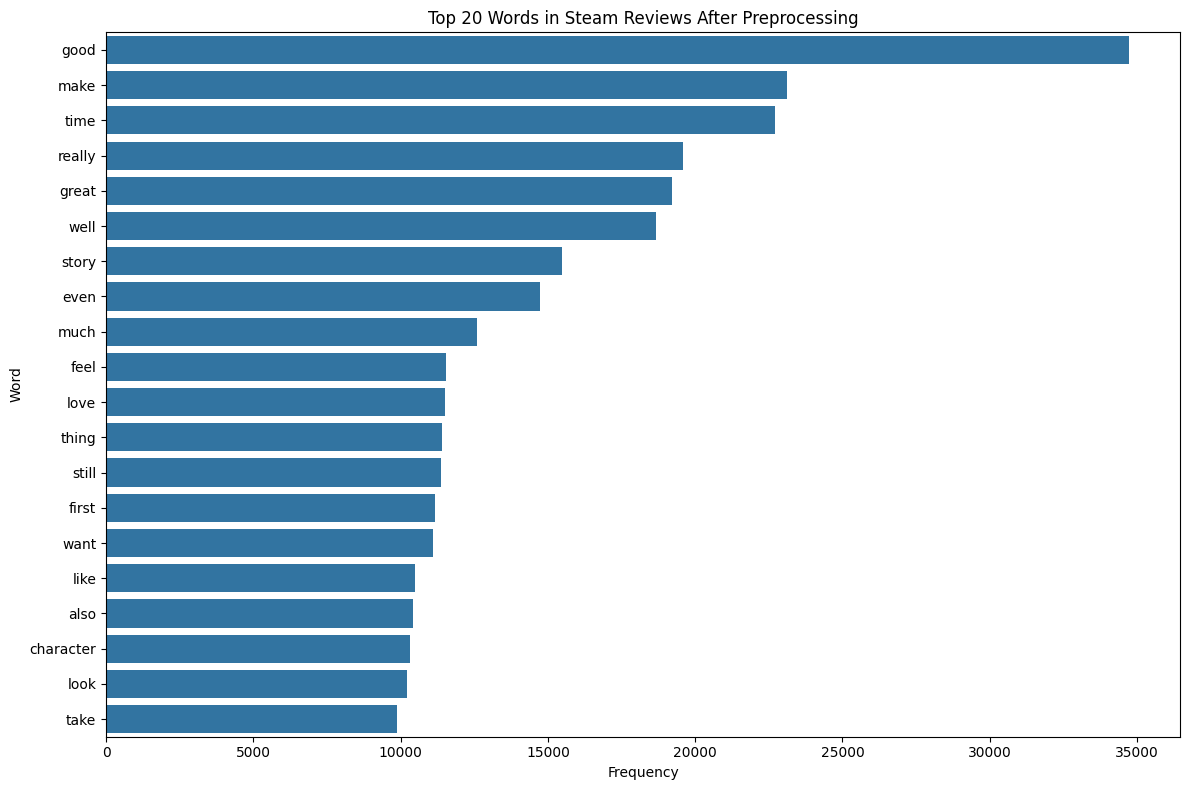

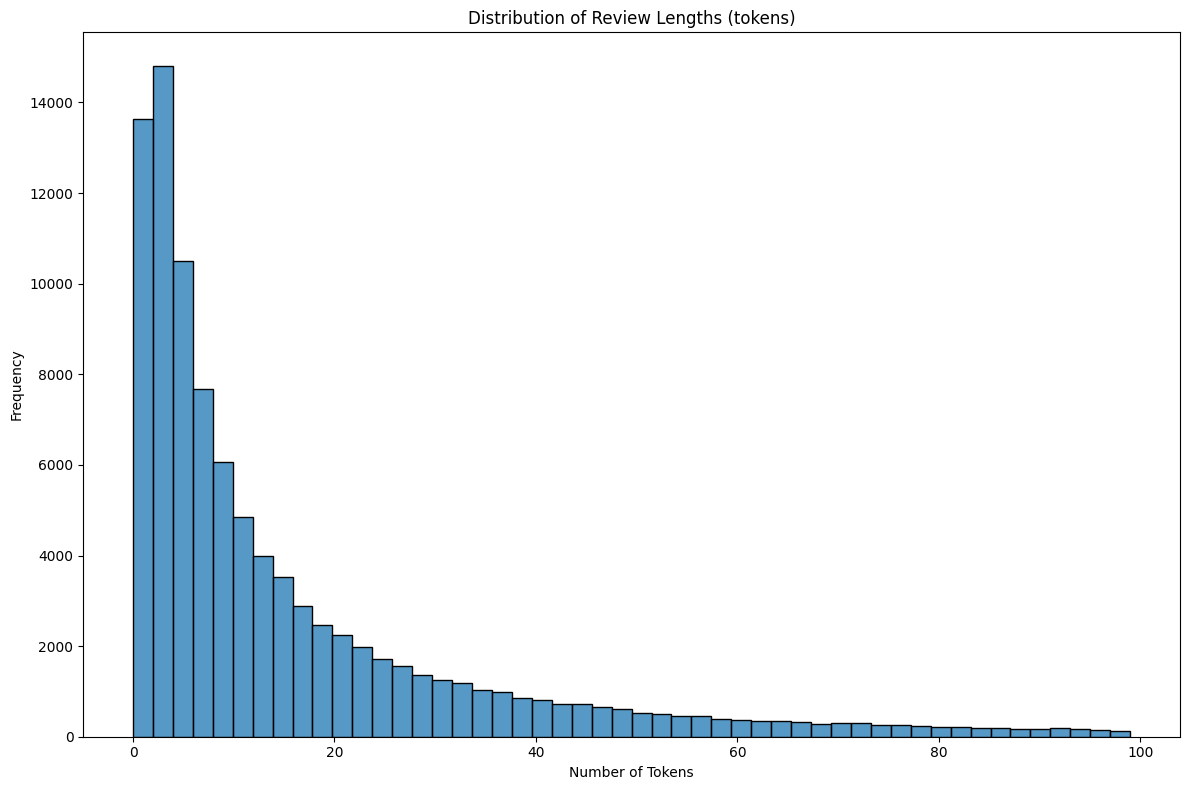

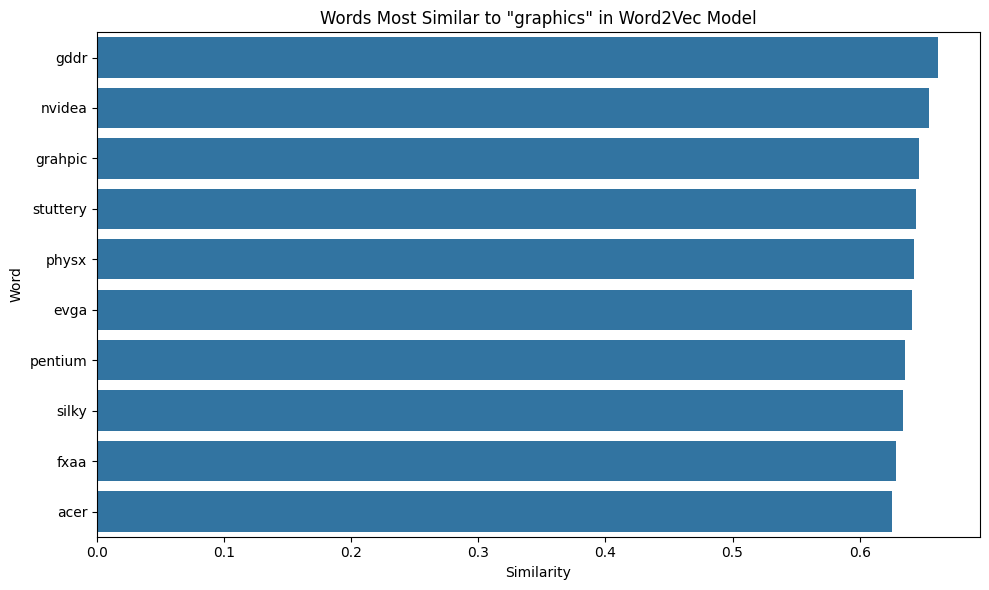

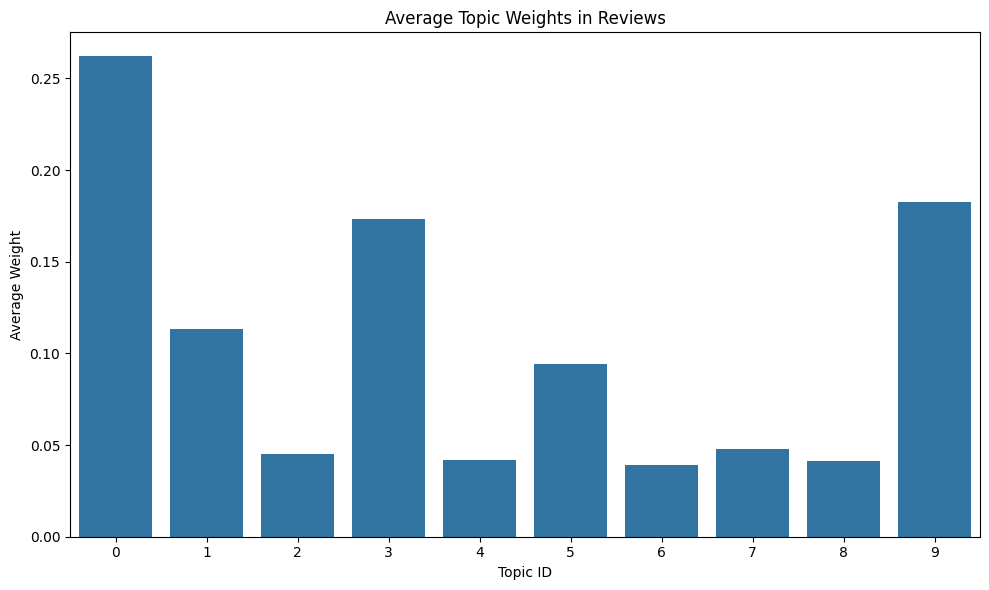

Visualizations created and saved.


In [ ]:
# Visualization of preprocessing results
def visualize_results(df_reviews, word2vec_model, lda_model):
    print("Creating visualizations...")
    
    # Visualization 1: Most common words after preprocessing
    all_words = [word for tokens in df_reviews['spacy_tokens'] for word in tokens]
    word_freq = pd.Series(all_words).value_counts()
    
    plt.figure(figsize=(12, 8))
    sns.barplot(x=word_freq.head(20).values, y=word_freq.head(20).index)
    plt.title('Top 20 Words in Steam Reviews After Preprocessing')
    plt.xlabel('Frequency')
    plt.ylabel('Word')
    plt.tight_layout()
    plt.savefig('processed_data/top_words.png')
    plt.show()
    
    # Visualization 2: Review length distribution
    plt.figure(figsize=(12, 8))
    review_lengths = df_reviews['spacy_tokens'].apply(len)
    sns.histplot(review_lengths[review_lengths < 100], bins=50)
    plt.title('Distribution of Review Lengths (tokens)')
    plt.xlabel('Number of Tokens')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.savefig('processed_data/review_length_distribution.png')
    plt.show()
    
    # Visualization 3: Word2Vec word similarity example (if model has enough words)
    try:
        similar_words = word2vec_model.wv.most_similar('graphics', topn=10)
        
        plt.figure(figsize=(10, 6))
        words, similarities = zip(*similar_words)
        sns.barplot(x=list(similarities), y=list(words))
        plt.title('Words Most Similar to "graphics" in Word2Vec Model')
        plt.xlabel('Similarity')
        plt.ylabel('Word')
        plt.tight_layout()
        plt.savefig('processed_data/word2vec_similarity.png')
        plt.show()
    except KeyError:
        print("Word 'graphics' not in vocabulary or vocabulary too small for visualization")
    
    # Visualization 4: Topic Distribution
    try:
        topic_weights = []
        for i, doc in enumerate(corpus[:1000]):  # First 1000 documents
            topic_weights.append([w for _, w in lda_model[doc]])
            
        df_topics = pd.DataFrame(topic_weights)
        
        # Plot average weight of each topic
        plt.figure(figsize=(10, 6))
        sns.barplot(x=df_topics.columns, y=df_topics.mean())
        plt.title('Average Topic Weights in Reviews')
        plt.xlabel('Topic ID')
        plt.ylabel('Average Weight')
        plt.tight_layout()
        plt.savefig('processed_data/topic_distribution.png')
        plt.show()
    except:
        print("Could not visualize topic distribution")
    
    print("Visualizations created and saved.")

visualize_results(df_small_reviews, word2vec_model, lda_model)

In [ ]:
# Create Doc2Vec Vectorization 
def train_doc2vec(df_reviews):
    print("Training Doc2Vec model...")
    
    tagged_docs = [
        TaggedDocument(words=tokens, tags=[str(i)]) 
        for i, tokens in enumerate(df_reviews['spacy_tokens'])
    ]
    
    doc2vec_model = Doc2Vec(
        documents=tagged_docs,
        vector_size=300,     
        window=5,            
        min_count=5,         
        workers=4,           
        dm=1,                
        epochs=20            
    )
    
    doc2vec_model.save('models/doc2vec_model.model')
    
    # Get document vectors
    doc_vectors = np.array([doc2vec_model.dv[str(i)] for i in range(len(df_reviews))])
    
    print("Doc2Vec model training complete.")
    return doc2vec_model, doc_vectors

# Run the function
doc2vec_model, doc_vectors = train_doc2vec(df_small_reviews)

Training Doc2Vec model...
Doc2Vec model training complete.


In [ ]:
# Compare Vectorization Methods
print("Vectorization dimension comparison:")
print(f"TF-IDF: {tfidf_matrix.shape[1]} features")
print(f"Word2Vec document: {word2vec_model.vector_size} features")
print(f"Doc2Vec: {doc2vec_model.vector_size} features")
print(f"LDA Topics: {lda_model.num_topics} topics")


sample_idx = 0
print(f"\nSample document: {df_reviews.iloc[sample_idx]['text'][:100]}...")

# TF-IDF representation (sparse, show non-zero elements)
tfidf_vec = tfidf_matrix[sample_idx].toarray()[0]
nonzero_indices = np.nonzero(tfidf_vec)[0]
print(f"\nTF-IDF representation (showing {len(nonzero_indices)} non-zero elements out of {len(tfidf_vec)}):")
for idx in nonzero_indices[:5]:
    print(f"  {feature_names[idx]}: {tfidf_vec[idx]:.4f}")

# Word2Vec representation
word2vec_vec = df_small_reviews.iloc[sample_idx]['word2vec_vector']
print(f"\nWord2Vec document representation (first 5 dimensions):")
print(word2vec_vec[:5])

# Doc2Vec representation
doc2vec_vec = doc2vec_model.dv[str(sample_idx)]
print(f"\nDoc2Vec representation (first 5 dimensions):")
print(doc2vec_vec[:5])

# LDA topic representation
lda_topics = df_small_reviews.iloc[sample_idx]['lda_topics']
if lda_topics:
    print(f"\nLDA topic representation:")
    for topic_id, weight in lda_topics:
        print(f"  Topic {topic_id}: {weight:.4f}")
else:
    print("\nNo LDA topics for this document")

Vectorization dimension comparison:
TF-IDF: 5000 features
Word2Vec document: 300 features
Doc2Vec: 300 features
LDA Topics: 10 topics

Sample document: This would not be acceptable as an entertainment even back in the day when these graphics were all t...

TF-IDF representation (showing 5 non-zero elements out of 5000):
  balance: 0.5153
  just: 0.2357
  just one: 0.5706
  one: 0.2432
  word: 0.5424

Word2Vec document representation (first 5 dimensions):
[-0.20754896  0.26491153 -0.00460778 -0.01361732  0.08845758]

Doc2Vec representation (first 5 dimensions):
[0.04726619 0.07934806 0.01591515 0.00248372 0.01600847]

LDA topic representation:
  Topic 0: 0.2339
  Topic 1: 0.1032
  Topic 2: 0.0270
  Topic 3: 0.2048
  Topic 4: 0.0229
  Topic 5: 0.1393
  Topic 6: 0.0292
  Topic 7: 0.0321
  Topic 8: 0.0250
  Topic 9: 0.1825


In [ ]:
# Save Final Preprocessed Data and Summary
final_df = df_small_reviews[['product_id', 'username', 'text', 'cleaned_text', 'hours', 'date', 'found_funny']]

# Add information about vectorization
final_df['tokens_count'] = df_small_reviews['spacy_tokens'].apply(len)
final_df['has_word2vec'] = df_small_reviews['word2vec_vector'].apply(lambda x: not np.all(x == 0))
final_df['has_lda_topics'] = df_small_reviews['lda_topics'].apply(lambda x: x is not None)

# Save final dataset
final_df.to_csv('processed_data/final_preprocessed_data.csv', index=False)

/var/folders/vy/f_kjdqqn0gb75tr5ptwfjm000000gn/T/ipykernel_18018/3138542163.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['tokens_count'] = df_small_reviews['spacy_tokens'].apply(len)
/var/folders/vy/f_kjdqqn0gb75tr5ptwfjm000000gn/T/ipykernel_18018/3138542163.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final_df['has_word2vec'] = df_small_reviews['word2vec_vector'].apply(lambda x: not np.all(x == 0))
/var/folders/vy/f_kjdqqn0gb75tr5ptwfjm000000gn/T/ipykernel_18018/3138542163.py:8: Sett

Final preprocessing results saved.
Preprocessing pipeline complete!


In [ ]:
# Load the preprocessed reviews
def load_data():
    try:
        df = pd.read_csv('processed_data/final_preprocessed_data.csv')
        print(f"Loaded {len(df)} preprocessed reviews")
        return df
    except FileNotFoundError:
        print("Preprocessed data not found. Please run the preprocessing pipeline first.")
        return None

# Load the models created during preprocessing
def load_models():
    models = {}
    try:
        # Load TF-IDF model (both vectorizer and matrix)
        with open('models/tfidf_vectorizer.pkl', 'rb') as f:
            tfidf_data = pickle.load(f)
            if isinstance(tfidf_data, tuple) and len(tfidf_data) == 2:
                models['tfidf_vectorizer'], models['tfidf_matrix'] = tfidf_data
            elif isinstance(tfidf_data, dict):
                models['tfidf_vectorizer'] = tfidf_data.get('vectorizer')
                models['tfidf_matrix'] = tfidf_data.get('matrix')
            else:
                models['tfidf_model'] = tfidf_data
        print("TF-IDF model loaded")
    except Exception as e:
        print(f"Error loading TF-IDF model: {e}")
    
    try:
        # Load Word2Vec model
        models['word2vec'] = Word2Vec.load('models/word2vec_model.model')
        print("Word2Vec model loaded")
    except Exception as e:
        print(f"Word2Vec model not found: {e}")
    
    try:
        # Load Doc2Vec model
        models['doc2vec'] = Doc2Vec.load('models/doc2vec_model.model')
        print("Doc2Vec model loaded")
    except Exception as e:
        print(f"Doc2Vec model not found: {e}")
        
    try:
        # Load LDA model and dictionary
        with open('models/lda_model.model', 'rb') as f:
            models['lda_model'] = pickle.load(f)
        with open('models/lda_dictionary.dict', 'rb') as f:
            models['lda_dictionary'] = pickle.load(f)
        print("LDA model loaded")
    except Exception as e:
        print(f"LDA model not found: {e}")
        
    return models

df = load_data()
models = load_models()

Loaded 100000 preprocessed reviews
TF-IDF model loaded
Word2Vec model loaded
Doc2Vec model loaded
LDA model loaded


In [ ]:
class ContentBasedRecommender:
    def __init__(self, df, models):
        self.df = df
        self.models = models
        self.product_ids = df['product_id'].unique()
        self.product_id_to_idx = {pid: i for i, pid in enumerate(self.product_ids)}
        self.idx_to_product_id = {i: pid for i, pid in enumerate(self.product_ids)}
        self.prepare_data()
        
    def prepare_data(self):
        """Aggregate reviews by product_id and prepare game profiles"""
        # Group by product_id to aggregate reviews for each game
        self.game_reviews = self.df.groupby('product_id')
        
        print("Creating game profiles...")
        self.game_profiles = {}
        
        # Prepare document vectors if available
        if 'doc2vec' in self.models and self.models['doc2vec'] is not None:
            print("Using Doc2Vec model for content-based recommendations")
            self.prepare_doc2vec_profiles()
        elif 'word2vec' in self.models and self.models['word2vec'] is not None:
            print("Using Word2Vec model for content-based recommendations")
            self.prepare_word2vec_profiles()
        else:
            print("Using review text for content-based recommendations")
            self.prepare_text_profiles()
            
        # Calculate similarity matrix
        self.calculate_similarity_matrix()
    
    def prepare_doc2vec_profiles(self):
        """Create game profiles using Doc2Vec vectors"""
        model = self.models['doc2vec']
        
        # For each game, infer a vector from all its reviews
        for pid in self.product_ids:
            game_reviews = self.df[self.df['product_id'] == pid]
            if len(game_reviews) == 0:
                continue
                
            # Get all tokens from reviews for this game
            # Make sure each review is properly tokenized
            review_vectors = []
            
            for _, row in game_reviews.iterrows():
                try:
                    # Ensure we have a list of tokens, not a string
                    if isinstance(row['cleaned_text'], str):
                        tokens = row['cleaned_text'].split()
                        # Only use if there are actual tokens
                        if tokens:
                            vec = model.infer_vector(tokens)
                            review_vectors.append(vec)
                except Exception as e:
                    print(f"Error inferring vector for game {pid}: {e}")
                    continue
            
            # Only create a profile if we have at least one valid review vector
            if review_vectors:
                game_vector = np.mean(review_vectors, axis=0)
                self.game_profiles[pid] = game_vector
    
    def prepare_word2vec_profiles(self):
        """Create game profiles using Word2Vec vectors"""
        model = self.models['word2vec']
        
        # For each game, create a vector from all its reviews
        for pid in self.product_ids:
            try:
                game_reviews = self.df[self.df['product_id'] == pid]
                if len(game_reviews) == 0:
                    continue
                    
                # Get all tokens from reviews for this game
                all_word_vectors = []
                
                for _, row in game_reviews.iterrows():
                    if isinstance(row['cleaned_text'], str):
                        tokens = row['cleaned_text'].split()
                        for token in tokens:
                            try:
                                if token in model.wv:
                                    all_word_vectors.append(model.wv[token])
                            except:
                                # Skip tokens not in vocabulary
                                continue
                
                # Create vector for game using word vectors
                if all_word_vectors:
                    game_vector = np.mean(all_word_vectors, axis=0)
                    self.game_profiles[pid] = game_vector
            except Exception as e:
                print(f"Error processing game {pid}: {e}")
                continue
    
    def prepare_text_profiles(self):
        """Create game profiles using raw text frequency"""
        try:
            from sklearn.feature_extraction.text import TfidfVectorizer
            
            # Aggregate all reviews for each game
            game_texts = {}
            for pid in self.product_ids:
                game_reviews = self.df[self.df['product_id'] == pid]
                if len(game_reviews) > 0:
                    cleaned_texts = [text for text in game_reviews['cleaned_text'].tolist() if isinstance(text, str)]
                    if cleaned_texts:
                        game_texts[pid] = " ".join(cleaned_texts)
            
            # Create TF-IDF vectors for each game
            if game_texts:
                vectorizer = TfidfVectorizer(max_features=1000, min_df=2, max_df=0.8)
                tfidf_matrix = vectorizer.fit_transform(list(game_texts.values()))
                for i, pid in enumerate(game_texts.keys()):
                    self.game_profiles[pid] = tfidf_matrix[i].toarray().flatten()
            else:
                print("No valid game texts found for TF-IDF vectorization")
        except Exception as e:
            print(f"Error in text profile creation: {e}")
            self._create_simple_profiles()
    
    def _create_simple_profiles(self):
        """Create simple word count profiles as fallback"""
        from collections import Counter
        
        for pid in self.product_ids:
            game_reviews = self.df[self.df['product_id'] == pid]
            if len(game_reviews) > 0:
                # Create a simple word count vector
                word_counts = Counter()
                for text in game_reviews['cleaned_text']:
                    if isinstance(text, str):
                        word_counts.update(text.split())
                
                if word_counts:
                    # Convert to a simple normalized vector
                    total = sum(word_counts.values())
                    if total > 0:
                        profile = np.zeros(100)  # Simple fixed-size profile
                        for i, (word, count) in enumerate(word_counts.most_common(100)):
                            profile[i] = count / total
                        self.game_profiles[pid] = profile
    
    def calculate_similarity_matrix(self):
        """Calculate cosine similarity between game profiles"""
        print("Calculating game similarity matrix...")
        
        # Extract vectors in consistent order
        profile_vectors = []
        self.profile_indices = {}
        i = 0
        
        for pid in self.product_ids:
            if pid in self.game_profiles:
                profile_vectors.append(self.game_profiles[pid])
                self.profile_indices[pid] = i
                i += 1
        
        if profile_vectors:
            try:
                profile_matrix = np.vstack(profile_vectors)
                self.similarity_matrix = cosine_similarity(profile_matrix)
            except Exception as e:
                print(f"Error calculating similarity matrix: {e}")
                self.similarity_matrix = np.zeros((len(profile_vectors), len(profile_vectors)))
        else:
            print("No game profiles created")
            self.similarity_matrix = np.array([])
    
    def get_similar_games(self, product_id, n=10):
        """Get n most similar games to the given product_id"""
        try:
            if product_id not in self.profile_indices:
                print(f"Product ID {product_id} not found in profiles")
                return []
                
            game_idx = self.profile_indices[product_id]
            
            # Get similarity scores for this game
            similarity_scores = self.similarity_matrix[game_idx]
            
            # Get indices of most similar games (excluding self)
            similar_indices = np.argsort(similarity_scores)[::-1][1:n+1]
            
            # Map indices back to product IDs and scores
            similar_games = []
            profile_pid_map = {v: k for k, v in self.profile_indices.items()}
            
            for idx in similar_indices:
                pid = profile_pid_map[idx]
                score = similarity_scores[idx]
                similar_games.append((pid, score))
                
            return similar_games
        except Exception as e:
            print(f"Error getting similar games: {e}")
            return []

In [ ]:
class CollaborativeRecommender:
    def __init__(self, df, factors=50, iterations=10):  # Reduced complexity for stability
        self.df = df
        self.factors = factors
        self.iterations = iterations
        self.model = None
        self.user_to_idx = None
        self.idx_to_user = None
        self.game_to_idx = None
        self.idx_to_game = None
        self.user_game_matrix = None
        self.prepare_data()
        
    def prepare_data(self):
        """Prepare user-game interaction matrix for collaborative filtering"""
        print("Preparing user-game matrix for collaborative filtering...")
        
        try:
            # Create user and game id mappings
            users = self.df['username'].unique()
            games = self.df['product_id'].unique()
            
            self.user_to_idx = {user: i for i, user in enumerate(users)}
            self.idx_to_user = {i: user for i, user in enumerate(users)}
            self.game_to_idx = {game: i for i, game in enumerate(games)}
            self.idx_to_game = {i: game for i, game in enumerate(games)}
    
            user_indices = []
            game_indices = []
            values = []
            
            for _, row in self.df.iterrows():
                user_idx = self.user_to_idx.get(row['username'])
                game_idx = self.game_to_idx.get(row['product_id'])
                
                if user_idx is not None and game_idx is not None:
                    try:
                        # Use hours played as interaction strength (with some minimum value)
                        hours = float(row['hours']) if pd.notna(row['hours']) else 0.1
                        hours = max(hours, 0.1)  # Ensure positive value
                        
                        user_indices.append(user_idx)
                        game_indices.append(game_idx)
                        values.append(float(hours))
                    except (ValueError, TypeError):
                        # Skip if hours can't be converted to float
                        continue
            
            # Create sparse matrix
            self.user_game_matrix = sparse.coo_matrix(
                (values, (user_indices, game_indices)), 
                shape=(len(users), len(games))
            ).tocsr()
            
            print(f"Created matrix with {len(users)} users and {len(games)} games")
        except Exception as e:
            print(f"Error preparing data for collaborative filtering: {e}")
            # Create an empty matrix as fallback
            self.user_game_matrix = sparse.csr_matrix((1, 1))
        
    def train_model(self):
        """Train the collaborative filtering model"""
        print("Training collaborative filtering model...")
        
        try:
            # Check if we have enough data
            if self.user_game_matrix.nnz < 10:
                print("Not enough data for collaborative filtering")
                return False
                
            # Initialize ALS model with error handling
            self.model = AlternatingLeastSquares(
                factors=self.factors,
                iterations=self.iterations,
                calculate_training_loss=True,
                random_state=42
            )
            
            # Train on the user-game matrix
            self.model.fit(self.user_game_matrix)
            print("Model training complete")
            return True
        except Exception as e:
            print(f"Error training collaborative model: {e}")
            return False
        
    def get_similar_games(self, product_id, n=10):
        """Get n most similar games to the given product_id based on collaborative filtering"""
        try:
            if self.model is None:
                print("Collaborative model not trained")
                return []
                
            if product_id not in self.game_to_idx:
                print(f"Product ID {product_id} not found in collaborative model")
                return []
                
            # Get the item factors for the game
            game_idx = self.game_to_idx[product_id]
            
            # Find similar games
            similar_indices, similar_scores = self.model.similar_items(game_idx, n+1)
            
            # Map indices back to product IDs and scores (exclude the first one which is itself)
            similar_games = []
            for idx, score in zip(similar_indices[1:], similar_scores[1:]):
                pid = self.idx_to_game[idx]
                similar_games.append((pid, float(score)))
                
            return similar_games
        except Exception as e:
            print(f"Error getting collaborative recommendations: {e}")
            return []

In [ ]:
class GameRecommender:
    def __init__(self, df, models, content_weight=0.5):
        self.df = df
        self.models = models
        self.content_weight = content_weight
        print("Initializing content-based recommender...")
        self.content_recommender = ContentBasedRecommender(df, models)
        print("Initializing collaborative recommender...")
        self.collaborative_recommender = CollaborativeRecommender(df)
        self.collaborative_trained = self.collaborative_recommender.train_model()
        self.game_info = self._prepare_game_info()
        
    def _prepare_game_info(self):
        """Prepare additional information about games for recommendations"""
        game_info = {}
        
        try:
            # Aggregate data for each game
            for pid in self.df['product_id'].unique():
                game_reviews = self.df[self.df['product_id'] == pid]
                if len(game_reviews) > 0:
                    # Calculate average hours and sample review text
                    hours = [h for h in game_reviews['hours'] if pd.notna(h)]
                    avg_hours = np.mean(hours) if hours else 0
                    
                    # Get a sample review text
                    sample_review = ""
                    for text in game_reviews['text']:
                        if isinstance(text, str) and len(text) > 10:
                            sample_review = text[:100] + "..."  # First 100 chars
                            break
                    
                    game_info[pid] = {
                        'product_id': pid,
                        'review_count': len(game_reviews),
                        'avg_hours': avg_hours,
                        'sample_review': sample_review
                    }
        except Exception as e:
            print(f"Error preparing game info: {e}")
        
        return game_info
    
    def get_game_info(self, product_id):
        """Get information about a specific game"""
        return self.game_info.get(product_id, {'product_id': product_id, 'not_found': True})
    
    def get_recommendations(self, product_id, n=10, method='hybrid'):
        """Get game recommendations using the specified method"""
        try:
            if method == 'content':
                return self._get_content_recommendations(product_id, n)
            elif method == 'collaborative' and self.collaborative_trained:
                return self._get_collaborative_recommendations(product_id, n)
            elif method == 'hybrid' and self.collaborative_trained:
                return self._get_hybrid_recommendations(product_id, n)
            else:
                # Default to content-based if collaborative not available
                print(f"Using content-based as fallback for {method} method")
                return self._get_content_recommendations(product_id, n)
        except Exception as e:
            print(f"Error getting recommendations: {e}")
            return []
    
    def _get_content_recommendations(self, product_id, n=10):
        """Get content-based recommendations"""
        similar_games = self.content_recommender.get_similar_games(product_id, n)
        return self._format_recommendations(similar_games)
    
    def _get_collaborative_recommendations(self, product_id, n=10):
        """Get collaborative filtering recommendations"""
        similar_games = self.collaborative_recommender.get_similar_games(product_id, n)
        return self._format_recommendations(similar_games)
    
    def _get_hybrid_recommendations(self, product_id, n=10):
        """Get hybrid recommendations by combining content and collaborative approaches"""
        try:
            # Get recommendations from both systems
            content_games = self.content_recommender.get_similar_games(product_id, n*2)
            collab_games = self.collaborative_recommender.get_similar_games(product_id, n*2)
            
            # Create dictionaries for easier merging
            content_dict = {pid: score for pid, score in content_games}
            collab_dict = {pid: score for pid, score in collab_games}
            
            # Merge recommendations
            all_games = set(content_dict.keys()) | set(collab_dict.keys())
            hybrid_scores = {}
            
            for game in all_games:
                # Default scores of 0 if not in either list
                content_score = content_dict.get(game, 0)
                collab_score = collab_dict.get(game, 0)
                
                # Weighted combination
                hybrid_scores[game] = (self.content_weight * content_score + 
                                      (1 - self.content_weight) * collab_score)
            
            # Sort by hybrid score and take top n
            top_games = sorted(hybrid_scores.items(), key=lambda x: x[1], reverse=True)[:n]
            return self._format_recommendations(top_games)
        except Exception as e:
            print(f"Error in hybrid recommendations: {e}")
            # Fallback to content-based
            return self._get_content_recommendations(product_id, n)
    
    def _format_recommendations(self, similar_games):
        """Format the recommendation results with additional game info"""
        recommendations = []
        
        for pid, score in similar_games:
            game_data = self.get_game_info(pid)
            game_data['similarity_score'] = score
            recommendations.append(game_data)
            
        return recommendations
    
    def visualize_recommendations(self, product_id, n=10, method='hybrid'):
        """Visualize the recommendations"""
        try:
            recommendations = self.get_recommendations(product_id, n, method)
            
            if not recommendations:
                print(f"No recommendations found for product ID {product_id}")
                return []
            
            # Get the source game info
            source_game = self.get_game_info(product_id)
            if 'not_found' in source_game:
                print(f"Source game with product ID {product_id} not found")
                return []
                
            plt.figure(figsize=(10, 6))
            game_ids = [str(rec['product_id']) for rec in recommendations]
            scores = [rec['similarity_score'] for rec in recommendations]
            
            plt.barh(range(len(game_ids)), scores, align='center')
            plt.yticks(range(len(game_ids)), game_ids)
            plt.xlabel('Similarity Score')
            plt.ylabel('Product ID')
            plt.title(f'Games Similar to {product_id} ({method.capitalize()} Method)')
            plt.tight_layout()
            
            # Save the visualization
            os.makedirs('recommendations', exist_ok=True)
            plt.savefig(f'recommendations/game_{product_id}_{method}_recommendations.png')
            plt.close()
            
            # Also create a text report
            report = f"Recommendations for Game {product_id}\n"
            report += f"Method: {method.capitalize()}\n"
            report += f"Source Game: Product ID {product_id}, {source_game['review_count']} reviews, "
            report += f"Avg Hours: {source_game.get('avg_hours', 'N/A'):.1f}\n\n"
            
            report += "Recommended Games:\n"
            for i, rec in enumerate(recommendations, 1):
                report += f"{i}. Product ID: {rec['product_id']}, "
                report += f"Score: {rec['similarity_score']:.4f}, "
                report += f"Reviews: {rec.get('review_count', 'N/A')}, "
                report += f"Avg Hours: {rec.get('avg_hours', 'N/A'):.1f}\n"
                report += f"   Sample Review: {rec.get('sample_review', 'N/A')}\n"
            
            with open(f'recommendations/game_{product_id}_{method}_recommendations.txt', 'w') as f:
                f.write(report)
                
            print(f"Recommendations for game {product_id} saved to file")
            return recommendations
        except Exception as e:
            print(f"Error visualizing recommendations: {e}")
            return []
    

In [ ]:
def test_recommender():
    """Test the recommender system with sample games"""
    df = load_data()
    models = load_models()
    
    recommender = GameRecommender(df, models)
    
    # Get some sample game IDs to test
    sample_games = df['product_id'].value_counts().head(5).index.tolist()
    
    for game_id in sample_games:
        print(f"\nTesting recommendations for game {game_id}:")
        
        # Try different recommendation methods
        for method in ['content', 'collaborative', 'hybrid']:
            print(f"\n{method.capitalize()} Recommendations:")
            recommendations = recommender.visualize_recommendations(game_id, n=5, method=method)
            
            if recommendations:
                for i, rec in enumerate(recommendations, 1):
                    print(f"{i}. Game {rec['product_id']}, Score: {rec['similarity_score']:.4f}")


Loaded 100000 preprocessed reviews
TF-IDF model loaded
Word2Vec model loaded
Doc2Vec model loaded
LDA model loaded
Initializing content-based recommender...
Creating game profiles...
Using Doc2Vec model for content-based recommendations
Calculating game similarity matrix...
Initializing collaborative recommender...
Preparing user-game matrix for collaborative filtering...
Created matrix with 90114 users and 7065 games
Training collaborative filtering model...


  0%|          | 0/10 [00:00<?, ?it/s]

Model training complete

Testing recommendations for game 440:

Content Recommendations:
Recommendations for game 440 saved to file
1. Game 730, Score: 0.9631
2. Game 240, Score: 0.9567
3. Game 304930, Score: 0.9552
4. Game 359550, Score: 0.9549
5. Game 444090, Score: 0.9540

Collaborative Recommendations:
Recommendations for game 440 saved to file
1. Game 250460, Score: 0.7236
2. Game 235460, Score: 0.7233
3. Game 224900, Score: 0.7215
4. Game 15370, Score: 0.7200
5. Game 284850, Score: 0.7184

Hybrid Recommendations:
Recommendations for game 440 saved to file
1. Game 730, Score: 0.4815
2. Game 240, Score: 0.4784
3. Game 304930, Score: 0.4776
4. Game 359550, Score: 0.4774
5. Game 444090, Score: 0.4770

Testing recommendations for game 252490:

Content Recommendations:
Recommendations for game 252490 saved to file
1. Game 346110, Score: 0.9311
2. Game 221100, Score: 0.9254
3. Game 299740, Score: 0.9239
4. Game 344760, Score: 0.9192
5. Game 433850, Score: 0.9165

Collaborative Recommend